### Table of Contents

- [Load the data](#Load-the-data)
- [Some functions for quick-n-dirty data exploration](#Some-functions-for-quick-n-dirty-data-exploration)
- [Explore the data](#Explore-the-data)
- [Select the best features](#Select-the-best-features)
    - [$\chi^2$ and mutual info based feature selection](#$\chi^2$-and-mutual-info-based-feature-selection)
    - [Recursive Feature Elimination](#Recursive-Feature-Elimination)
    - [Feature Selection from Model](#Feature-Selection-from-Model)
    - [Particle Swarm Optimization for feature selection](#Particle-Swarm-Optimization-for-feature-selection)
    - [Best Features](#Best-Features)
- [Define the data prep func](#Define-the-data-prep-func)
    - [Verify the data prep routines](#Verify-the-data-prep-routines)

In [1]:
# some common imports

from operator import itemgetter
import sqlite3

# cloudpickle supports pickling for lambda expressions, functions and classes 
# defined interactively in the __main__ module
try:
    import cloudpickle as pickle
except ImportError:
    import pickle
    

In [2]:
# some common settings

# adjust settings to show all cols and rows
pd.options.display.max_columns = 80
pd.options.display.max_rows = 20


### Load the data

In [3]:
# load the train data set
# now, the dataframe df holds the data

with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
    df = pd.read_sql_query('SELECT * FROM loan', con=db)
    
df.set_index('id', inplace=True)    
df.index = df.index.astype(int)

df.shape

(621167, 73)

### Some functions for quick-n-dirty data exploration

In [4]:
# quick-n-dirty exploratory dataframe to facilitate data prep 

def edf():
    
    global df
    
    # show
    ef = pd.concat([ pd.DataFrame( np.round( 100*df.isnull().sum() / len(df) )).T,  # % of nulls
                     pd.DataFrame( df.isnull().sum() ).T, # num of nulls
                     pd.DataFrame( df.apply(lambda s: len(s.unique())) ).T, # cardinality
                     pd.DataFrame( df.dtypes ).T, # dtypes
                     df.sample(3)
                   ],ignore_index=True,
                 )
    ef.index = ['pct_nulls','num_nulls', 'cardinality', 'dtype', 'row1', 'row2', 'row3']
    ef = ef[ ef.columns.sort_values() ]
    
    return ef # returns the exploratory df


In [5]:
# quick-n-dirty func to explore raw feature values

def rfv(feature=None, raw=False):
    
    with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
        
        if feature is None:
            # if no feature passed in, then return the list of features to choose from
            ret_list = [ t[0] for t in db.execute("SELECT * FROM loan limit 1").description ]
            return ret_list
            
        # otherwise return the feature col
        res = db.execute('SELECT {feature} FROM loan'.format(feature=feature)).fetchall()
        s = pd.Series((t[0] for t in res))
        
    if raw: 
        return s # returns the raw values
    
    return s.value_counts(dropna=False).sort_index() 
                        

In [6]:
# quick-n-dirty func to explore the crosstab of raw feature values against the DEFAULT response or ch2's p-value

def rfch2(feature, normalize_ct=True, ret_pvalue=False):
        
    with sqlite3.connect('lending-club-loan-data/train.sqlite') as db:
       
        # build df from sql    
        res = db.execute('SELECT "DEFAULT", {feature} FROM loan'.format(feature=feature)).fetchall()
        f = pd.DataFrame( ((t[0],t[1]) for t in res), columns=['DEFAULT',feature])
            
        if f[ f[feature].isnull() ].size > 0:
            # if there are nulls, then make 2 categories 'nulls', not-nulls'
            binning_method = "np.where( f['{feature}'].isnull(), 'null', 'not-null' )".format(feature=feature)
        else:
            # if no nulls, then bin the values into 5 buckets and assign means to their values
            binning_method = ( "f.groupby( pd.cut(f['{feature}'], 5) )"
                               "['{feature}'].transform(lambda v: int(v.mean()))"
                              .format(feature=feature) )

    # build the crosstab DEFAULT against the feature
    ct = pd.crosstab( f.DEFAULT, eval(binning_method, globals(), locals()), 
                      rownames=['Loan Status'], colnames=[feature], 
                      dropna=False, normalize=normalize_ct)

    # reorder the crosstab cells (1 means loan defaults)
    ct = ct.reindex([1,0])
        
    if ret_pvalue: # compute and return the chi2's p-value
        from scipy.stats import chi2_contingency
        return chi2_contingency(ct)[1] 
        
    return ct # returns the crosstab


### Explore the data

In [7]:
# check our data frame, ie its cols, how many nulls, cardnality, dtypes, a few rows
edf()

,DEFAULT,acc_now_delinq,addr_state,all_util,annual_inc,annual_inc_joint,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,desc,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,home_ownership,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,max_bal_bc,member_id,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,next_pymnt_d,open_acc,open_acc_6m,open_il_12m,open_il_24m,open_il_6m,open_rv_12m,open_rv_24m,out_prncp,out_prncp_inv,policy_code,pub_rec,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,title,tot_coll_amt,tot_cur_bal,total_acc,total_bal_il,total_cu_tl,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
pct_nulls,0,0,0,98,0,100,0,0,0,0,86,0,100,0,0,6,0,0,0,0,98,0,98,98,0,0,0,0,0,0,2,0,98,0,51,75,85,98,29,0,98,98,98,98,98,98,0,0,0,0,0,0,0,0,0,0,0,0,8,8,0,98,98,0,0,0,0,0,8,0,0,100,0
num_nulls,0,23,0,606306,2,620819,0,0,114,23,532974,0,620821,23,0,36006,0,0,0,0,608223,0,606306,606306,23,0,0,0,40,0,12333,0,606306,0,318271,466016,525223,606700,177083,23,606306,606306,606306,606306,606306,606306,0,0,0,23,0,0,0,0,357,0,0,97,49178,49178,23,606306,606306,0,0,0,0,0,49178,0,0,620819,0
cardinality,2,9,51,1095,38115,226,2,14819,13,29,87306,4059,319,690,12,223019,1371,7343,7,6,1203,2,19,30,28,61814,539,103,102,179097,99,1371,8764,621167,146,165,124,188,99,75,14,13,18,34,16,27,189778,203022,1,31,14,2,16462,66286,1298,35,2,46408,8666,273465,128,12269,33,381481,381731,266685,4629,201736,16331,621167,3,4,924
dtype,int64,float64,object,float64,float64,float64,object,float64,float64,float64,object,float64,float64,object,object,object,float64,float64,object,object,float64,object,float64,float64,float64,float64,object,object,object,float64,object,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object
row1,0,0,MI,NaN,69996,NaN,INDIVIDUAL,0,0,0,None,22.12,NaN,Jan-1988,10+ years,Village of Pinckney,1800,1800,B,OWN,NaN,f,NaN,NaN,1,41.97,14.09%,Jul-2012,Jan-2016,41.97,Jan-2016,1800,NaN,1.66162e+06,35,NaN,NaN,NaN,Feb-2016,14,NaN,NaN,NaN,NaN,NaN,NaN,666.18,666.18,1,0,car,n,0,4667,32.4%,B5,60 months,Safari van,NaN,NaN,45,NaN,NaN,1783.63,1783.63,634.81,15,1133.82,NaN,https://www.lendingclub.com/browse/loanDetail....,Verified,None,481xx
row2,0,0,CA,NaN,129312,NaN,INDIVIDUAL,0,0,0,Borrower added on 01/05/10 > Credit cards we...,17.4,NaN,Jan-1986,8 years,San Diego State University & Foundation,20000,19800,B,MORTGAGE,NaN,f,NaN,NaN,0,659.37,11.48%,Jan-2010,Feb-2013,695.14,Jan-2013,20000,NaN,599930,NaN,NaN,NaN,NaN,Feb-2013,12,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,credit_card,n,0,230420,33.8%,B2,36 months,On the path to debt free,NaN,NaN,33,NaN,NaN,23730.9,23493.6,3730.87,0,20000,NaN,https://www.lendingclub.com/browse/loanDetail....,Verified,None,921xx
row3,0,0,FL,NaN,37000,NaN,INDIVIDUAL,0,0,0,None,21.18,NaN,May-1985,8 years,Baldwin-Fairchild Funeral Home,5000,5000,D,RENT,NaN,f,NaN,NaN,1,182,18.49%,Mar-2013,Jan-2016,182.27,Jan-2016,5000,NaN,4.59352e+06,71,71,90,NaN,Feb-2016,5,NaN,NaN,NaN,NaN,NaN,NaN,355.45,355.45,1,1,credit_card,n,0,5385,84.1%,D2,36 months,Credit card refinance,0,11983,11,NaN,NaN,6188.27,6188.27,1543.72,0,4644.55,6400,https://www.lendingclub.com/browse/loanDetail....,Not Verified,None,327xx


In [8]:
# look like we've got to do some cleaning ...

In [9]:
# let's start off by dropping features in cols_to_drop, as they do not seem to carry much of a predictive signal

cols_to_drop = [
    # these can be totally made up
    'desc', 'emp_title', 'purpose', 'title', 
    # !! investigate if they trully do not have any predictive power; try to stem, lem, tf-idf, T-SNE, etc
    
    # these ones are totally arbitrary
    'member_id', 'url', 

    # gonna keep sub_grade which is more specific than grade, so grade is dropped
    'grade',

    # gonna keep zip_codes which is more specific than addr_state
    'addr_state', # BTW: if the same zip code appears in two different states then that is incorrect 
                  # and the mapping state to zip_code should be investigated
    
    'mths_since_last_record', # 'The number of months since the last public record'
    
    'next_pymnt_d', # it is mostly null
    'last_pymnt_d', # ditto
]

df = df.drop(cols_to_drop, axis=1)

In [10]:
# next let's check the cols with more than 90% of nulls

f = edf()
very_sparse_cols = f.columns[ f.loc['pct_nulls'] > 90 ]
very_sparse_cols

Index(['all_util', 'annual_inc_joint', 'dti_joint', 'il_util', 'inq_fi',
       'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m',
       'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m',
       'open_rv_24m', 'total_bal_il', 'total_cu_tl',
       'verification_status_joint'],
      dtype='object')

In [11]:
# below it shows that for all the cols in very_sparse_cols,
# if the col is null then it is very slighly more likely that the loan defaults
# e.g. for 'dti_joint', we've got

# the overall prob of DEFAULT
NoDefault, Default = rfv('"DEFAULT"') / len(df)
# NoDefault, Default should give 93.3% good loans, 6.6% defaults, respectively
NoDefault, Default

(0.9335734190644384, 0.06642658093556161)

In [12]:
# the prob of DEFAULT given 'dti_joint' is null
Default_given_null_col, NoDefault_given_null_col =  rfch2('dti_joint')['null']

# so, the increase in prob of DEFAULT given 'dti_joint' is null
Default_given_null_col/(Default_given_null_col + NoDefault_given_null_col) - Default/(Default + NoDefault)

3.379975388027867e-05

In [13]:
# since the increase in prob is very small (less than ca 3.5e-3%), for now then, let's drop very_sparse_cols
df.drop(very_sparse_cols, axis=1, inplace=True)

In [14]:
edf()

,DEFAULT,acc_now_delinq,annual_inc,application_type,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,term,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verification_status,zip_code
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,75,0,0,0,0,0,0,0,0,0,0,0,8,8,0,0,0,0,0,0,8,0,0
num_nulls,0,23,2,0,0,114,23,0,23,0,0,0,0,0,23,0,0,0,40,0,0,318271,466016,23,0,0,0,23,0,0,0,357,0,0,49178,49178,23,0,0,0,0,0,49178,0,0
cardinality,2,9,38115,2,14819,13,29,4059,690,12,1371,7343,6,2,28,61814,539,103,102,179097,1371,146,165,75,189778,203022,1,31,2,16462,66286,1298,35,2,8666,273465,128,381481,381731,266685,4629,201736,16331,3,924
dtype,int64,float64,float64,object,float64,float64,float64,float64,object,object,float64,float64,object,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object
row1,0,0,95078,INDIVIDUAL,0,0,0,24.79,Oct-1994,9 years,11400,11400,RENT,w,1,363.42,9.17%,Jul-2015,Jan-2016,363.42,11400,NaN,NaN,19,9710.17,9710.17,1,0,n,0,32707,63.1%,B2,36 months,0,65846,37,2168.9,2168.9,479.07,0,1689.83,51800,Verified,945xx
row2,0,0,61000,INDIVIDUAL,0,0,0,23.82,Feb-1985,10+ years,9000,9000,MORTGAGE,f,0,281.62,7.90%,May-2012,Jan-2016,2205.48,9000,NaN,NaN,8,0,0,1,0,n,0,27834,88.4%,A4,36 months,NaN,NaN,22,10086.4,10086.4,1086.43,0,9000,NaN,Not Verified,290xx
row3,0,0,43000,INDIVIDUAL,0,0,0,7.93,Sep-2007,5 years,12175,12175,MORTGAGE,f,2,423.91,15.31%,Aug-2012,Apr-2015,2071.08,12175,NaN,NaN,7,0,0,1,0,n,0,4774,88.4%,C2,36 months,0,116739,18,15210.7,15210.7,3035.67,0,12175,5400,Source Verified,800xx


In [15]:
# now, let's fix some data types

# first, convert date_cols to date
date_cols = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
df[date_cols] = df[date_cols].apply(lambda s: pd.to_datetime(s).dt.date)

# then, if earliest_cr_line is null then set it to issue_d
df['earliest_cr_line'].where( df['earliest_cr_line'].notnull(), df['issue_d'], inplace=True)

# convert some date types to timedeltas, since deltas are more likely to be meaningful than dates
event_cols = ['earliest_cr_line', 'last_credit_pull_d']
df[event_cols] = df[event_cols].apply(lambda s: (s - df.issue_d).dt.days )
df.earliest_cr_line *= -1 # change the sign, as earliest_cr_line is before issue_d

# drop issue_d
# NB: issue_d may play an important role with some macroeconomic data, but for now just lose it
df = df.drop('issue_d', axis=1) # and drop issue_d

In [16]:
# fillna and encode last_credit_pull_d
df.last_credit_pull_d = pd.cut( df.last_credit_pull_d , 9).factorize(sort=True)[0]
df[ df.last_credit_pull_d == -1] = 10 # na_sentinel=10 in factorize() doesn't work !? hence the hack

# fillna and encode mths_since_last_delinq
df.mths_since_last_delinq = pd.cut( df.mths_since_last_delinq , 9).factorize(sort=True)[0]
df[ df.mths_since_last_delinq == -1] = 10

# fillna and encode mths_since_last_major_derog
df.mths_since_last_major_derog = pd.cut( df.mths_since_last_major_derog , 9).factorize(sort=True)[0]
df[ df.mths_since_last_major_derog == -1] = 10

In [17]:
# convert interest rates in ir_cols to float
ir_cols = ['int_rate', 'revol_util']
df[ir_cols] = df[ir_cols].apply(lambda v: pd.to_numeric(v.str.rstrip('%'), errors='ignore'))

In [18]:
# fillna cols_to_fillna_with_0 with 0  
cols_to_fillna_with_0 = [
    'acc_now_delinq',
    'collection_recovery_fee',
    'collections_12_mths_ex_med',
    'delinq_2yrs',
    'inq_last_6mths',
    'pub_rec',
    'revol_util',
    'total_rev_hi_lim',
]
df[cols_to_fillna_with_0] = df[cols_to_fillna_with_0].fillna(0)

In [19]:
# fillna with 1
cols_to_fillna_with_1 = [
    'open_acc', 
    'total_acc'
]
df[cols_to_fillna_with_1] = df[cols_to_fillna_with_1].fillna(1)

In [20]:
# fillna 'annual_inc' with the mean for each installment group
# the reasoning being, the higher the installment the higher the annual_inc must had been
df.annual_inc = df.groupby( pd.cut( df.installment, 10) ).annual_inc.transform( lambda s: s.fillna( s.mean() ) )

In [22]:
# next, let's try 'collection_recovery_fee' 
rfv('collection_recovery_fee') # it is mostly 0.0

0.0000       604678
0.0360            1
0.0630            1
0.0711            1
0.0745            1
0.1181            1
0.1348            1
0.1400            1
0.1800            1
0.1900            1
              ...  
4900.7500         1
4902.0800         1
5192.9900         1
5216.7400         1
5569.9200         1
5694.0936         1
5774.8000         1
6543.0400         1
6972.5900         1
7002.1900         1
Length: 14819, dtype: int64

In [23]:
rfch2('collection_recovery_fee') # but if it is > 0.0 than the proba of default increases

collection_recovery_fee,4.0,1857.0,3591.0,4875.0,6397.0
Loan Status,,,,,
1,0.066221,0.000156,0.000027,0.000014,0.000008
0,0.933573,0.000000,0.000000,0.000000,0.000000


In [24]:
# so, let's binarize 'collection_recovery_fee' to 0 and 1 
df.collection_recovery_fee = np.where( df.collection_recovery_fee > 0, 1, 0)

In [25]:
# fillna some other features with some other reasonable values 
df['tot_coll_amt'].fillna(df['loan_amnt'], inplace=True) # tot_coll_amt - 'Total collection amounts ever owed'
df['tot_cur_bal'].fillna(df['loan_amnt'], inplace=True)  # tot_cur_bal - 'Total current balance of all accounts'

# encoding zip_codes as 1's where DEFAULTs have occured and 0's, otherwise
zip_code_with_defaults = df[df.DEFAULT == 1]['zip_code'].unique()
df['zip_code_with_defaults'] = np.where( df['zip_code'].isin( zip_code_with_defaults ), 1, 0)
df.drop('zip_code', axis=1, inplace=True)

In [26]:
# encode some categoricals

# factorize factor_cols
factor_cols = [
    'application_type', 
    'initial_list_status', 
    'pymnt_plan', 
    'sub_grade', 
    'term'
]

for col in factor_cols:
    df[col] = df[col].astype('category').cat.as_ordered()
    df.insert( df.columns.get_loc(col), col+'_cd', df[col].cat.codes)
    # print out the category values for the reverse lookups 
    # later, df[new_col].cat.set_categories( df[cat_col].cat.categories, inplace=True );
    print('Cat Column:', col)
    print('Categories:', df[col].cat.categories)
    print( list(zip( np.arange(len( df[col].cat.categories )), df[col].cat.categories )) )
    print()
    df.drop(col, axis=1, inplace=True)
    

Cat Column: application_type
Categories: Index(['INDIVIDUAL', 'JOINT'], dtype='object')
[(0, 'INDIVIDUAL'), (1, 'JOINT')]

Cat Column: initial_list_status
Categories: Index(['f', 'w'], dtype='object')
[(0, 'f'), (1, 'w')]

Cat Column: pymnt_plan
Categories: Index(['n', 'y'], dtype='object')
[(0, 'n'), (1, 'y')]

Cat Column: sub_grade
Categories: Index(['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2',
       'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4',
       'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
      dtype='object')
[(0, 'A1'), (1, 'A2'), (2, 'A3'), (3, 'A4'), (4, 'A5'), (5, 'B1'), (6, 'B2'), (7, 'B3'), (8, 'B4'), (9, 'B5'), (10, 'C1'), (11, 'C2'), (12, 'C3'), (13, 'C4'), (14, 'C5'), (15, 'D1'), (16, 'D2'), (17, 'D3'), (18, 'D4'), (19, 'D5'), (20, 'E1'), (21, 'E2'), (22, 'E3'), (23, 'E4'), (24, 'E5'), (25, 'F1'), (26, 'F2'), (27, 'F3'), (28, 'F4'), (29, 'F5'), (30, 'G1'), (31, 'G2'), (32, 'G3'), (33, 'G4'),

In [27]:
# encode emp_length    
def encode_emp_length(v):
    if v in (['1 year','2 years']):
        return 1
    elif v in (['3 year','4 years']):
        return 2
    elif v in (['5 year','6 years']):
        return 3
    elif v in (['7 year','8 years','9 year']):
        return 4            
    elif v in (['10 years', '10+ years']):
        return 5                           
    else:
        return 0
df['emp_length'] = df['emp_length'].apply(encode_emp_length)  


# factorize int_rate by rounding it
df.int_rate = 100*(df.int_rate/100).astype(int)    
    
    
# factorize dti
df['dti'] = pd.cut( df.dti, np.arange(0,1.1,.1).tolist() + [2,3,5,10,30,100] ).factorize(sort=True)[0]      


# factorize earliest_cr_line
df.earliest_cr_line = pd.qcut( df.earliest_cr_line , 9 ).factorize(sort=True)[0] 
df[ df.earliest_cr_line == -1] = 10 # na_sentinel=10 doesn't work !??

In [28]:
# let's get_dummies (ie get in one-hot-encoding) 

# for home_ownership
df = ( df.join ( pd.get_dummies( # convert cat values of home_ownership to dummies
                                 df.home_ownership.str.lower().replace({'none':'other'}), 
                                 prefix='home_ownship' 
                               )
               )
      
      .drop(  # drop now superfluous 'home_ownership'
              ['home_ownership'], axis=1 
              # 'ownership_other' can also be droped to remove multicollinearity
              # but multicollinearity does not reduce the predictive power or reliability of the model
              # it only causes erratic changes of coefficient estimates in regression models
              # for other models, such as GBM or DNN, it can be actually helpful
          )
     )

# for verification_status
df = ( df.join( pd.get_dummies( # convert cat values of verification_status to dummies
                                df.verification_status.str.lower().str.replace(r'\s+','_'),  
                                prefix='verif_stat' 
                              )
              )
      
      .drop(  # drop now superfluous 'verification_status' 
              ['verification_status'], axis=1 
              # 'verif_stat_not_verified' can also be droped to remove multicollinearity
              # but see the note for home_ownership above
          )
     )

# for verification_status_joint
# cardinality of verification_status_joint is 2, so for now do not bother
"""
df = ( df.join( pd.get_dummies( # convert cat values of verification_status_joint to dummies
                                df.verification_status_joint.str.lower().str.replace(r'\s+','_'),  
                                prefix='verif_stat_joint' 
                              )
              )
      
      .drop(  # drop now superfluous 'verification_status' 
              ['verification_status_joint'], axis=1 
              # 'verif_stat_joint_not_verified' can also be droped to remove multicollinearity
              # but see the note above
          )
     )
""";

In [29]:
# reduce the cardinality for cols_to_reduce_cardinality
cols_to_reduce_cardinality = [
    ('annual_inc', 1000),
    ('funded_amnt', 1000),
    ('funded_amnt_inv', 1000),
    ('installment', 100),
    ('last_pymnt_amnt', 100),
    ('loan_amnt', 100),
    ('out_prncp', 1000),
    ('out_prncp_inv', 1000),
    ('recoveries', 100),
    ('revol_bal', 100),
    ('revol_util', 10),
    ('tot_coll_amt', 1000),    
    ('tot_cur_bal', 1000),
    ('total_pymnt', 1000),
    ('total_pymnt_inv', 1000),
    ('total_rec_int', 1000),
    ('total_rec_late_fee', 10),
    ('total_rec_prncp', 1000),
    ('total_rev_hi_lim', 1000),
]
for col, divisor in cols_to_reduce_cardinality:
    df[col] = df[col].groupby( pd.cut( df[col], 100) ).transform( lambda v: divisor * np.round(v.mean()/divisor,0) )

In [30]:
# finally let's check our final df (should be no nulls, low cardinalities, and all numerics)
edf()

,DEFAULT,acc_now_delinq,annual_inc,application_type_cd,collection_recovery_fee,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownship_any,home_ownship_mortgage,home_ownship_other,home_ownship_own,home_ownship_rent,initial_list_status_cd,inq_last_6mths,installment,int_rate,last_credit_pull_d,last_pymnt_amnt,loan_amnt,mths_since_last_delinq,mths_since_last_major_derog,open_acc,out_prncp,out_prncp_inv,policy_code,pub_rec,pymnt_plan_cd,recoveries,revol_bal,revol_util,sub_grade_cd,term_cd,tot_coll_amt,tot_cur_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verif_stat_not_verified,verif_stat_source_verified,verif_stat_verified,zip_code_with_defaults
pct_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
num_nulls,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
cardinality,2,8,46,2,2,12,28,17,9,6,35,36,2,2,2,2,2,2,27,15,1,10,100,100,10,10,74,39,39,1,30,2,67,37,21,35,2,31,73,127,59,58,24,25,36,17,2,2,2,2
dtype,int64,float64,float64,int8,int64,float64,float64,int64,int64,int64,float64,float64,uint8,uint8,uint8,uint8,uint8,int8,float64,float64,int64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,int8,float64,float64,float64,int8,int8,float64,float64,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,int64
row1,0,0,57000,0,0,0,0,14,0,0,5000,5000,0,0,0,0,1,0,2,200,0,5,2000,4800,0,0,4,0,0,1,0,0,0,11500,50,6,0,0,22000,4,5000,5000,1000,0,5000,26000,0,1,0,1
row2,0,0,57000,0,0,0,0,15,8,4,10000,10000,0,1,0,0,0,1,3,400,0,3,200,10000,3,3,12,10000,10000,1,0,0,0,11500,80,15,0,0,404000,22,0,0,0,0,0,26000,1,0,0,1
row3,0,0,57000,0,0,0,0,15,7,0,8000,8000,0,1,0,0,0,1,3,300,0,3,200,8000,0,0,27,7000,7000,1,0,0,0,38300,30,2,0,0,68000,40,1000,1000,0,0,1000,130000,1,0,0,1


### Select the best features

In [31]:
# there are about 50 features left
# let's now check which ones are important for the predictive task
df.shape

(621167, 50)

#### $\chi^2$ and mutual info based feature selection

In [32]:
# let's first try chi2 and mutual_info_classif (these are univariate relationships)
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, mutual_info_classif

In [33]:
y = df.iloc[:,0] # the DEFAULT col
X = df.iloc[:,1:] # the remaining cols

In [44]:
# estimate the mutual_info_classif between 'DEFAULT' (ie bad loan) and each individual col

feature_selector = SelectKBest(mutual_info_classif, k='all')
feature_selector.fit(X, y)

SelectKBest(k='all',
      score_func=<function mutual_info_classif at 0x7f5a68fa8ea0>)

In [45]:
sorted_features = sorted( list(zip(X.columns, feature_selector.scores_)), key=itemgetter(1), reverse=True )

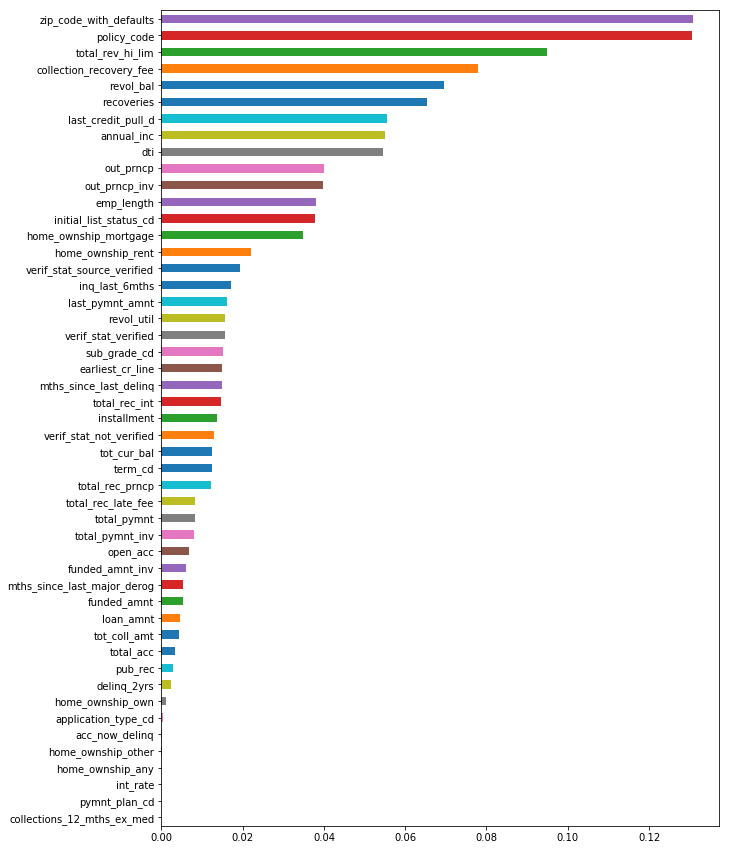

In [47]:
s = pd.Series( {k:v for k,v in sorted_features} ).sort_values()
plt.figure(figsize=(10,15))
s.plot.barh();

In [48]:
# pickle the best features_from_mutual_info_classif
with open( "features_from_mutual_info_classif.pkl", "wb" ) as fh:
    pickle.dump(sorted_features[:], fh )

In [34]:
with open( "features_from_mutual_info_classif.pkl", "rb" ) as fh:
    best_features_from_mutual_info_classif = pickle.load(fh)

In [35]:
fset_from_mutual_info_classif = {k for k,v in best_features_from_mutual_info_classif[:25]}

#### Feature Selection from Model

In [36]:
# estimate feature_importances_ using, say, ensemble of trees

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

In [52]:
clf = ExtraTreesClassifier()
clf = clf.fit(X, y)

In [53]:
sorted_features = sorted( list(zip(X.columns, clf.feature_importances_)), key=itemgetter(1), reverse=True )

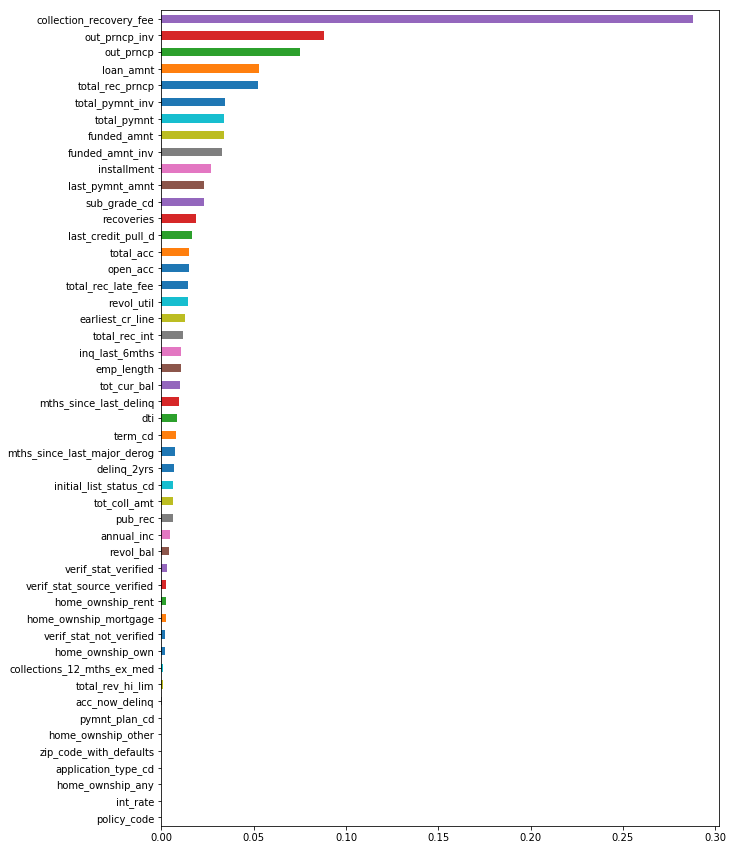

In [54]:
s = pd.Series( {k:v for k,v in sorted_features} ).sort_values()

plt.figure(figsize=(10,15))
s.plot.barh();

In [55]:
# pickle the best features_from_extra_trees_clf

with open( "features_from_extra_trees_clf.pkl", "wb" ) as fh:
    pickle.dump(sorted_features[:], fh )

In [37]:
with open( "features_from_extra_trees_clf.pkl", "rb" ) as fh:
    best_features_from_extra_trees_clf = pickle.load(fh)

In [38]:
fset_from_extra_trees_clf = {k for k,v in best_features_from_extra_trees_clf[:25]}

#### Recursive Feature Elimination

In [ ]:
# !! work for the future

In [ ]:
# RFECV
from sklearn.feature_selection import RFECV

In [39]:
# hold on, RFECV, or Recursive Feature Elimination, runs a cross-validation loop to find the optimal number 
# of features. It starts with the initial num of features, estimating coef_ or feature_importances_, then 
# it looses the least important ones, and repeats the process; 
# it is quite effective, but it takes time and time is a scarce resource; 
# so running RFECV is contingent on the availability of time

#### Particle Swarm Optimization for feature selection

In [39]:
# !! work for the future

In [40]:
# estimate feature importances using PSO
import pyswarms as ps

#### Best Features

In [44]:
# combine the best feature sets and pickle them

combined_feature_set = fset_from_mutual_info_classif | fset_from_extra_trees_clf

with open( "best_predictive_features.pkl", "wb" ) as fh:
    pickle.dump( list(combined_feature_set), fh )

In [45]:
with open( "best_predictive_features.pkl", "rb" ) as fh:
        best_features = pickle.load( fh )
        
len(best_features)

35

In [46]:
sorted(best_features)

['annual_inc',
 'collection_recovery_fee',
 'dti',
 'earliest_cr_line',
 'emp_length',
 'funded_amnt',
 'funded_amnt_inv',
 'home_ownship_mortgage',
 'home_ownship_rent',
 'initial_list_status_cd',
 'inq_last_6mths',
 'installment',
 'last_credit_pull_d',
 'last_pymnt_amnt',
 'loan_amnt',
 'mths_since_last_delinq',
 'open_acc',
 'out_prncp',
 'out_prncp_inv',
 'policy_code',
 'recoveries',
 'revol_bal',
 'revol_util',
 'sub_grade_cd',
 'tot_cur_bal',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int',
 'total_rec_late_fee',
 'total_rec_prncp',
 'total_rev_hi_lim',
 'verif_stat_source_verified',
 'verif_stat_verified',
 'zip_code_with_defaults']

### Define the data prep func

In [53]:
# now let's create a file with code that can be imported by other notebooks and executed therin

In [2]:
%%writefile LC_data_prep.py
 
# this py module contains funcs related to the data from LendingClub 
# the data is gonna train our models to predict bad (ie defaulted) loans
# it contains:
#   - _execute_data_trans_workflow(df) 
#   - load_and_prep_data(load_test_data=False)
#   - load_raw_rows(load_test_data=False, raw_cols='loan_amnt, term, int_rate')
 
    
# standard imports
import sqlite3
import numpy as np
import pandas as pd

# cloudpickle supports pickling for lambda expressions, functions and classes 
# defined interactively in the __main__ module
try:
    import cloudpickle as pickle
except ImportError:
    import pickle

    

# _execute_data_trans_workflow() is internal and should not be used from the outside
def _execute_data_trans_workflow(df):
    # what follows is just a copy from the data exploration phase
    # this is big and ugly, so with more free time 
    # !! rewrite the whole data preparation workflow
    """
    internal/hidden/private func
    Do not use from outside! 
    _execute_data_trans_workflow(df) is kinda messy and gonna be changed
    """

    cols_to_drop = [
        'desc', 'emp_title', 'purpose', 'title', 
        'member_id', 'url', 
        'grade',
        'addr_state', 
        'mths_since_last_record', 
        'next_pymnt_d', 
        'last_pymnt_d',
    ]
    df = df.drop(cols_to_drop, axis=1)

    very_sparse_cols = [
           'all_util', 'annual_inc_joint', 'dti_joint', 'il_util', 'inq_fi',
           'inq_last_12m', 'max_bal_bc', 'mths_since_rcnt_il', 'open_acc_6m',
           'open_il_12m', 'open_il_24m', 'open_il_6m', 'open_rv_12m',
           'open_rv_24m', 'total_bal_il', 'total_cu_tl',
           'verification_status_joint']
    df.drop(very_sparse_cols, axis=1, inplace=True)

    date_cols = ['earliest_cr_line', 'issue_d', 'last_credit_pull_d']
    df[date_cols] = df[date_cols].apply(lambda s: pd.to_datetime(s).dt.date)

    df['earliest_cr_line'].where( df['earliest_cr_line'].notnull(), df['issue_d'], inplace=True)

    event_cols = ['earliest_cr_line', 'last_credit_pull_d']
    df[event_cols] = df[event_cols].apply(lambda s: (s - df.issue_d).dt.days )
    df.earliest_cr_line *= -1

    df = df.drop('issue_d', axis=1)

    df.last_credit_pull_d = pd.qcut( df.last_credit_pull_d , 9).factorize(sort=True)[0]
    df[ df.last_credit_pull_d == -1] = 10

    df.mths_since_last_delinq = pd.qcut( df.mths_since_last_delinq , 9).factorize(sort=True)[0]
    df[ df.mths_since_last_delinq == -1] = 10

    df.mths_since_last_major_derog = pd.qcut( df.mths_since_last_major_derog , 9).factorize(sort=True)[0]
    df[ df.mths_since_last_major_derog == -1] = 10

    ir_cols = ['int_rate', 'revol_util']
    df[ir_cols] = df[ir_cols].apply(lambda v: pd.to_numeric(v.str.rstrip('%'), errors='ignore'))  

    cols_to_fillna_with_0 = [
        'acc_now_delinq',
        'collection_recovery_fee',
        'collections_12_mths_ex_med',
        'delinq_2yrs',
        'inq_last_6mths',
        'pub_rec',
        'revol_util',
        'total_rev_hi_lim',
    ]
    df[cols_to_fillna_with_0] = df[cols_to_fillna_with_0].fillna(0)

    cols_to_fillna_with_1 = [
        'open_acc', 
        'total_acc'
    ]
    df[cols_to_fillna_with_1] = df[cols_to_fillna_with_1].fillna(1)

    df.annual_inc = df.groupby( pd.cut( df.installment, 10) ).annual_inc.transform( lambda s: s.fillna( s.mean() ) )

    df.collection_recovery_fee = np.where( df.collection_recovery_fee > 0, 1, 0)

    df['tot_coll_amt'].fillna(df['loan_amnt'], inplace=True) 
    df['tot_cur_bal'].fillna(df['loan_amnt'], inplace=True)  

    zip_code_with_defaults = df[df.DEFAULT == 1]['zip_code'].unique()
    df['zip_code_with_defaults'] = np.where( df['zip_code'].isin( zip_code_with_defaults ), 1, 0)
    df.drop('zip_code', axis=1, inplace=True)

    factor_cols = [
        'application_type', 
        'initial_list_status', 
        'pymnt_plan', 
        'sub_grade', 
        'term'
    ]
    for col in factor_cols:
        df[col] = df[col].astype('category').cat.as_ordered()
        df.insert( df.columns.get_loc(col), col+'_cd', df[col].cat.codes)
        df.drop(col, axis=1, inplace=True)

    def encode_emp_length(v):
        if v in (['1 year','2 years']):
            return 1
        elif v in (['3 year','4 years']):
            return 2
        elif v in (['5 year','6 years']):
            return 3
        elif v in (['7 year','8 years','9 year']):
            return 4            
        elif v in (['10 years', '10+ years']):
            return 5                           
        else:
            return 0
    df['emp_length'] = df['emp_length'].apply(encode_emp_length)  

    df.int_rate = (100*df.int_rate/100).astype(int)    

    df['dti'] = pd.cut(df.dti, np.arange(0,1.1,.1).tolist() + [2,3,5,10,30,100]).factorize(sort=True)[0]      

    df.earliest_cr_line = pd.qcut( df.earliest_cr_line , 9).factorize(sort=True)[0] 
    df[ df.earliest_cr_line == -1] = 10    

    df = ( df.join ( pd.get_dummies( 
                                     df.home_ownership.str.lower().replace({'none':'other'}), 
                                     prefix='home_ownship' 
                                   )
                   )

          .drop(  
                  ['home_ownership'], axis=1 
              )
         )


    df = ( df.join( pd.get_dummies( 
                                    df.verification_status.str.lower().str.replace(r'\s+','_'),  
                                    prefix='verif_stat' 
                                  )
                  )

          .drop(  
                  ['verification_status'], axis=1 
              )
         )

    cols_to_reduce_cardinality = [
        ('annual_inc', 1000),
        ('funded_amnt', 1000),
        ('funded_amnt_inv', 1000),
        ('installment', 100),
        ('last_pymnt_amnt', 100),
        ('loan_amnt', 100),
        ('out_prncp', 1000),
        ('out_prncp_inv', 1000),
        ('recoveries', 100),
        ('revol_bal', 100),
        ('revol_util', 10),
        ('tot_coll_amt', 1000),    
        ('tot_cur_bal', 1000),
        ('total_pymnt', 1000),
        ('total_pymnt_inv', 1000),
        ('total_rec_int', 1000),
        ('total_rec_late_fee', 10),
        ('total_rec_prncp', 1000),
        ('total_rev_hi_lim', 1000),
    ]
    for col, divisor in cols_to_reduce_cardinality:
        df[col] = df[col].groupby( pd.cut( df[col], 100) ).transform( lambda v: divisor * np.round(v.mean()/divisor,0) )

    return df



# this is for the data preparation workflow
def load_and_prep_data(load_test_data=False):
    """
    This function loads the train or test data, transforms and returns them in a data frame.
    
    Attributes:
    -----------
    load_test_data : whether to load train or test data
    
    Returns:
    --------
    df : the dataframe with the prepared data
    
    """
 
    if load_test_data:
        file_to_open = 'lending-club-loan-data/test.sqlite'
    else:
        file_to_open = 'lending-club-loan-data/train.sqlite'

    with sqlite3.connect(file_to_open) as db:
        df = pd.read_sql_query('SELECT * FROM loan', con=db)
    
    df.set_index("id",inplace=True)
    df.index = df.index.astype(int)
    
    df = _execute_data_trans_workflow(df)

    best_features = ["DEFAULT"]
    with open( "best_predictive_features.pkl", "rb" ) as fh:
        best_features += pickle.load( fh )
    
    df = df[ sorted(best_features) ]

    return df


# this is to extract the raw data, such as id, member_id, etc
def load_raw_rows(load_test_data=False, raw_cols='loan_amnt, term, int_rate'):
    """
    Loads the raw (as is) data
    
    Parameters
    ----------
    raw_cols : str defining the sql columns to use in SELECT
    
    Returns
    --------
    df : the data frame with the raw data
    """

    if load_test_data:
        file_to_open = 'lending-club-loan-data/test.sqlite'
    else:
        file_to_open = 'lending-club-loan-data/train.sqlite'

    with sqlite3.connect(file_to_open) as db:
        df = pd.read_sql_query('SELECT id, "DEFAULT", member_id, {raw_cols} FROM loan'.format(raw_cols=raw_cols), con=db)
        
    df.set_index("id",inplace=True)   
    
    df.index = df.index.astype(int)
    df.member_id = df.member_id.astype(int)
    
    if df.columns.contains('term'): df.term = np.where( df.term.str.contains('36'), 36, 60)
    if df.columns.contains('int_rate'): df.int_rate = df.int_rate.apply( lambda v: float(v.strip('%'))/100 )
    
    return df


Overwriting LC_data_prep.py


### Verify the data prep routines

##### **Start from here ** *(restart the kernel to verify the data preparation correctness)*

In [2]:
from LC_data_prep import load_and_prep_data

In [3]:
df = load_and_prep_data()
df.shape

(621167, 37)

In [4]:
# run the definition for edf at the top of this notebook
edf()

,DEFAULT,annual_inc,collection_recovery_fee,dti,earliest_cr_line,emp_length,funded_amnt,funded_amnt_inv,home_ownship_mortgage,home_ownship_rent,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,verif_stat_source_verified,verif_stat_verified,zip_code_with_defaults
pct_nulls,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
num_nulls,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cardinality,2,46,2,17,9,6,35,36,2,2,...,127,59,58,24,25,36,17,2,2,2
dtype,int64,float64,int64,int64,int64,int64,float64,float64,uint8,uint8,...,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,int64
1st row,0,57000,0,15,8,5,15000,15000,1,0,...,18,0,0,0,0,0,130000,0,1,1
2nd row,1,57000,1,15,0,1,2000,3000,0,1,...,12,1000,1000,0,20,1000,26000,0,0,1
3rd_row,0,124000,0,15,4,1,35000,35000,1,0,...,63,40000,40000,4000,0,35000,130000,1,0,1


###### [Please move to the next notebook: *3-A. Model Development*](3-A. Model Development.ipynb)